# Equal Access to Cash in the context of the 20 Minute Neighbourhood

### Chuang Wang    Jianan Wei    Iain Paton

## Urban Analytics Group Project 2022-2023

Equal access to cash is an issue identified within the context of the 20 minute neighbourhood, alongside other factors (Olsen, Thornton, Tregonning, Mitchell 2022) with prior analysis that indicates 4.6% of the UK population do not have access to a free-to-use cash machine (ATM) and are required to pay a transaction fee for withdrawing cash (Financial Conduct Authority 2021). This issue may have a disproportionate impact upon poorer people, who may have a greater reliance upon cash transactions, and this analysis investigates the relationship between deprivation and access to cash, in the context of industry subsidy schemes for ATM access (the LINK network) and further interventions to support community access to cash.

Data sources

Method


The conclusion is that  


## References

Jonathan R. Olsen, Lukar Thornton, Grant Tregonning, Richard Mitchell, 'Nationwide equity assessment of the 20-min neighbourhood in the Scottish context: A socio-spatial proximity analysis of residential locations', Social Science & Medicine, Volume 315, 2022.
House of Commons Library, 'Statistics on Access to Cash, Bank Branches and ATMs'. UK Parliment, London, UK, 2022.


## Data sources


Virtual environment my37env for geopandas

In [168]:
import numpy as np
import pandas as pd
import geopandas as gpd
from IPython.display import Markdown, display
import shapefile
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
import urllib3
import seaborn as sns
import contextily as ctx
from pandas import Series, DataFrame
from shapely.geometry import Point
from shapely.geometry import shape  
from zipfile import ZipFile
from io import StringIO
import scipy
from scipy import stats
from scipy.stats import norm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from IPython.core.display import HTML
from owslib.wfs import WebFeatureService
from owslib.util import Authentication
import requests

from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

%matplotlib inline

## 1a. Data: Cash Machines/ATMs
This dataset is published by the LINK network and categorises ATMs as "free" or "surcharging".

The columns and types are outlined below. There are a total of **4049** and **1026** free and surcharging ATMs in Scotland. 

In [169]:
atm_data = pd.read_csv('cashpoint_xy.csv')



The dataset columns are listed below in **Figure 1.1.**

In [170]:
print('\033[1m'+ "Figure 1.1. ATM Data Fields" + '\033[0m')
atm_data.columns

Figure 1.1. ATM Data Fields


Index(['x', 'y', 'Street Address', 'Postcode', 'Charge Type'], dtype='object')

In [171]:
print('\033[1m' + "Figure 1.2. ATMs by type" + '\033[0m' )
print(atm_data['Charge Type'].value_counts())

Figure 1.2. ATMs by type
Free           4049
Surcharging    1026
Name: Charge Type, dtype: int64


The data is plotted spatially below in **Figure 1.3.** and this provides an indication of the spatial distribution, prior to joining with socio-economic data.

C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


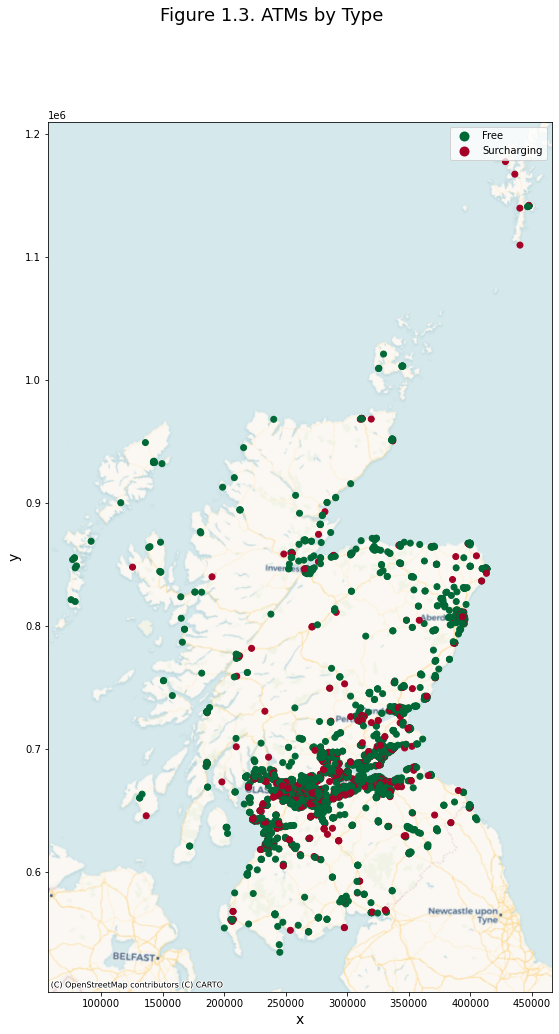

In [172]:
fig, ax = plt.subplots(figsize=(32,16))
geometry = [Point(xy) for xy in zip(atm_data['x'], atm_data['y'])]
crs = {'init': 'epsg:27700'}
atm_geodata = gpd.GeoDataFrame(atm_data, crs=crs, geometry=geometry)
plt.suptitle('Figure 1.3. ATMs by Type', fontsize=18)
plt.ylabel('y',fontsize=14)
plt.xlabel('x',fontsize=14)
atm_geodata.plot(ax=ax, column = 'Charge Type',cmap = 'RdYlGn_r',label = 'Charge Type', legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,crs='EPSG:27700')
plt.show()

## 1b. Data: SIMD

The Scottish Index of Multiple Deprivation (SIMD) is a relative and area-based measure of deprivation across 6,976 small area data zones. SIMD ranks data zones from most deprived (ranked 1) to least deprived (ranked 6,976) across a number of categories - income, employment, education, health, access to services, crime and housing - which also includes an aggregate ranking and is commonly arranged in deciles or quintiles.

This dataset will be spatially joined to the prior STATS19 dataset, which contains some socio-economic information, but not the full range of that within SIMD nor the individual datazone rankings.

The columns and a summary table description are shown below (**Figure 1.4** and **Figure 1.5**), prior to a visualisation of the data.


In [173]:
url = "https://maps.gov.scot/ATOM/shapefiles/SG_SIMD_2020.zip"
simdmap_df = gpd.read_file(url)
print('\033[1m' +"Figure 1.4. SIMD columns"+'\033[0m' )
simdmap_df.columns

Figure 1.4. SIMD columns


Index(['DataZone', 'DZName', 'LAName', 'SAPE2017', 'WAPE2017', 'Rankv2',
       'Quintilev2', 'Decilev2', 'Vigintilv2', 'Percentv2', 'IncRate',
       'IncNumDep', 'IncRankv2', 'EmpRate', 'EmpNumDep', 'EmpRank', 'HlthCIF',
       'HlthAlcSR', 'HlthDrugSR', 'HlthSMR', 'HlthDprsPc', 'HlthLBWTPc',
       'HlthEmergS', 'HlthRank', 'EduAttend', 'EduAttain', 'EduNoQuals',
       'EduPartici', 'EduUniver', 'EduRank', 'GAccPetrol', 'GAccDTGP',
       'GAccDTPost', 'GAccDTPsch', 'GAccDTSsch', 'GAccDTRet', 'GAccPTGP',
       'GAccPTPost', 'GAccPTRet', 'GAccBrdbnd', 'GAccRank', 'CrimeCount',
       'CrimeRate', 'CrimeRank', 'HouseNumOC', 'HouseNumNC', 'HouseOCrat',
       'HouseNCrat', 'HouseRank', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [174]:
print('\033[1m' +"Figure 1.5. SIMD description"+'\033[0m' )
simdmap_df.describe()

Figure 1.5. SIMD description


,SAPE2017,WAPE2017,Rankv2,Quintilev2,Decilev2,Vigintilv2,Percentv2,IncNumDep,IncRankv2,EmpNumDep,EmpRank,HlthCIF,HlthAlcSR,HlthDrugSR,HlthSMR,HlthEmergS,HlthRank,EduAttain,EduNoQuals,EduRank,GAccPetrol,GAccDTGP,GAccDTPost,GAccDTPsch,GAccDTSsch,GAccDTRet,GAccPTGP,GAccPTPost,GAccPTRet,GAccRank,CrimeCount,CrimeRate,CrimeRank,HouseNumOC,HouseNumNC,HouseRank,Shape_Leng,Shape_Area
count,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6976.000000,6.976000e+03
mean,777.637615,500.973481,3488.500000,3.000287,5.500573,10.501147,50.506881,93.830419,3488.497420,46.558343,3488.500000,102.611812,102.407970,98.080705,99.625430,100.995269,3488.500000,5.375678,102.006164,3488.500000,3.873343,3.572522,2.928165,3.052784,6.102149,5.341322,10.469642,8.873089,13.546277,3488.500000,22.303039,287.598767,3488.500000,82.332569,13.430619,3488.500000,11796.930969,1.117218e+07
std,219.108923,175.075939,2013.942071,1.414416,2.872487,5.766595,28.868218,76.620587,2013.937591,37.060114,2013.942049,57.308775,98.050585,134.777744,46.204359,34.974483,2013.942071,1.035270,55.676766,2013.942071,2.959359,2.823333,1.756975,1.372077,5.103192,6.000209,6.292236,4.741542,10.709859,2013.942071,32.849022,404.842613,2013.939363,63.921332,16.800241,2013.942063,34514.362402,5.656366e+07
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.660000,0.560000,0.650000,0.940000,1.020000,0.790000,1.600000,1.830000,1.840000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,561.481470,9.367268e+03
25%,635.000000,395.000000,1744.750000,2.000000,3.000000,5.750000,25.750000,34.000000,1744.750000,18.000000,1744.750000,55.000000,35.000000,16.000000,70.000000,74.000000,1744.750000,5.140000,58.000000,1744.750000,2.290000,2.020000,1.810000,2.220000,3.630000,2.880000,6.430000,5.720000,7.980000,1744.750000,7.000000,94.000000,1744.750000,35.000000,3.000000,1744.750000,2196.306838,1.336901e+05
50%,755.000000,475.000000,3488.500000,3.000000,5.500000,10.500000,50.500000,72.000000,3488.500000,36.000000,3488.500000,90.000000,74.000000,50.000000,93.000000,95.000000,3488.500000,5.545000,93.000000,3488.500000,3.170000,2.900000,2.535000,2.800000,4.890000,4.100000,8.960000,7.720000,11.250000,3488.500000,14.000000,194.000000,3488.500000,66.500000,8.000000,3488.500000,2968.399829,2.111272e+05
75%,886.000000,568.000000,5232.250000,4.000000,8.000000,15.250000,75.250000,133.000000,5232.250000,65.000000,5232.250000,140.000000,138.000000,133.000000,120.000000,123.000000,5232.250000,5.890000,140.000000,5232.250000,4.420000,4.210000,3.470000,3.530000,6.820000,6.040000,12.650000,10.620000,16.060000,5232.250000,28.000000,361.000000,5232.250000,112.000000,17.000000,5232.250000,4654.186576,4.141899e+05
max,3847.000000,3423.000000,6976.000000,5.000000,10.000000,20.000000,100.000000,656.000000,6969.000000,311.000000,6974.000000,370.000000,1656.000000,1826.000000,824.000000,399.000000,6976.000000,6.880000,353.000000,6976.000000,64.950000,89.380000,23.940000,29.890000,119.230000,190.000000,119.790000,41.010000,190.000000,6976.000000,1159.000000,12441.000000,6928.000000,490.000000,187.000000,6974.000000,893824.142207,1.162510e+09


SIMD is visualised spatially below in **Figure 1.6**.

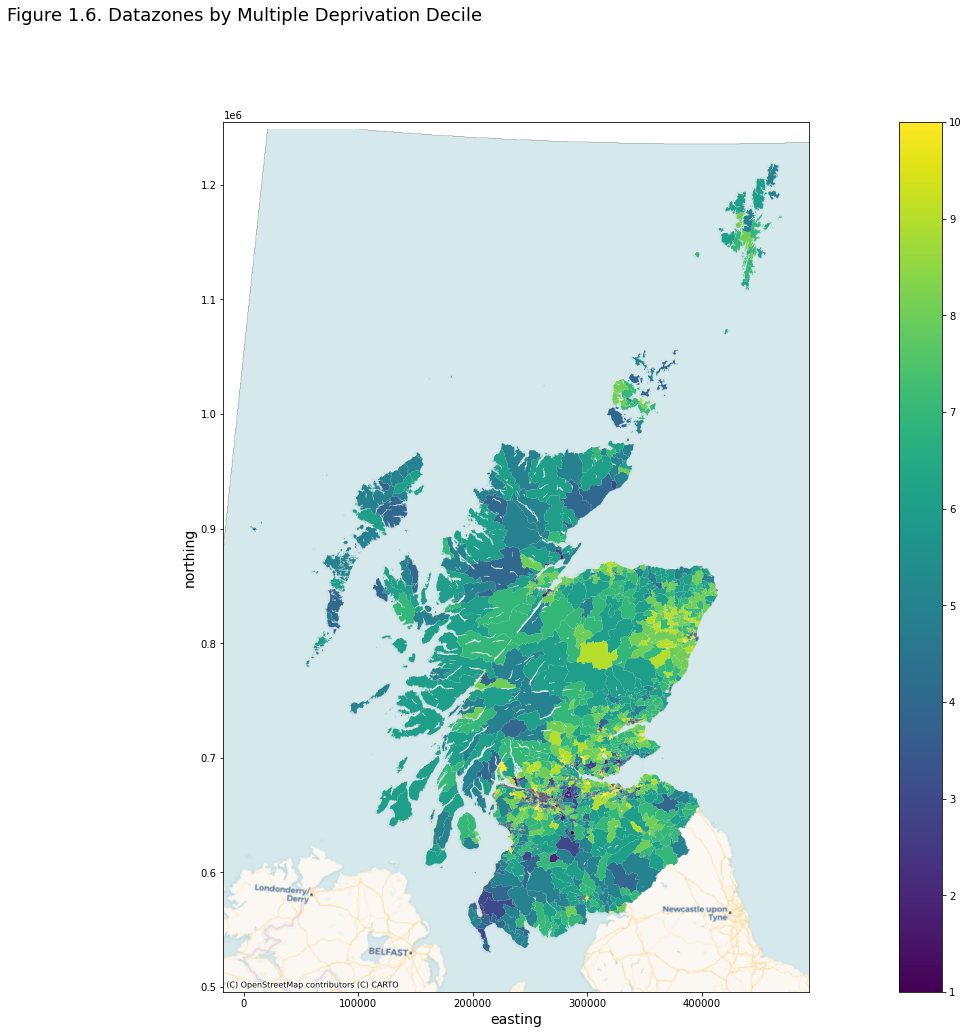

In [175]:
fig, ax = plt.subplots(figsize=(32,16))
plt.suptitle('Figure 1.6. Datazones by Multiple Deprivation Decile', fontsize=18)
plt.ylabel('northing',fontsize=14)
plt.xlabel('easting',fontsize=14)
simdmap_df.plot(ax=ax, column='Decilev2', linewidth = 0.1, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,crs='EPSG:27700')


# 1c. Data: Postcode Centroids

The postcode is the lowest-level postal address area geometry unit (other than the unique property reference number or UPRN, a building level of geometry). The use of associated postcode centroids provides sufficient granularity for an equivalent to residential population, in catchment analysis.

The headings and summary statistics are shown in **Figures 1.7 and 1.8** below. There are a tota of **160,768** postcodes across Scotland. 

In order to derive a subset of postcode centroids representing residential delivery points, the data is filtered for **"RP"** (residential delivery points) values greater than zero. This process is shown in **Figures 1.9 and 1.10** below and results in a sub total of **148,726** points.

The **mean** number of delivery points is **18** and the **maximum** is **100**.

The resultant postcode centroids are mapped by easting and northing in **Figure 1.11** below.

In [176]:
postcode_centroids = pd.concat(map(pd.read_csv, ['ab.csv', 'dd.csv','dg.csv','eh.csv', 'fk.csv','g.csv','hs.csv', 'iv.csv','ka.csv','kw.csv','ky.csv','ml.csv','pa.csv','ph.csv','td.csv','ze.csv']))

In [177]:
print('\033[1m'+ "Figure 1.7. Postcode Centroid Data Fields" + '\033[0m')
postcode_centroids.count()

Figure 1.7. Postcode Centroid Data Fields


PC    160768
PQ    160768
PR    160758
TP    160768
DQ    160768
RP    160768
BP    160768
PD    160768
MP    160768
UM    160768
EA    160768
NO    160768
CY    160768
RH       636
LH    160741
CC        11
DC    160741
WC    160741
LS    160768
dtype: int64

In [178]:
print('\033[1m' +"Figure 1.8. Postcode Centroids"+'\033[0m' )
postcode_centroids.describe()

Figure 1.8. Postcode Centroids


,PQ,TP,DQ,RP,BP,PD,MP,UM,EA,NO
count,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,160768.000000,1.607680e+05
mean,10.086460,17.678207,17.548455,16.964390,0.702553,0.011265,17.548455,0.129752,296229.878483,7.020987e+05
std,1.914398,15.745038,15.709437,15.757967,2.369294,0.105536,15.709437,1.307336,53222.856305,8.286128e+04
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,10.000000,6.000000,5.000000,5.000000,0.000000,0.000000,5.000000,0.000000,257412.000000,6.610948e+05
50%,10.000000,13.000000,13.000000,12.000000,0.000000,0.000000,13.000000,0.000000,290618.500000,6.729950e+05
75%,10.000000,26.000000,26.000000,25.000000,0.000000,0.000000,26.000000,0.000000,331482.000000,7.300795e+05
max,90.000000,100.000000,100.000000,100.000000,85.000000,1.000000,100.000000,84.000000,468851.000000,1.213615e+06


In [179]:
print('\033[1m' + "Figure 1.9. Postcode Centroids Residential Delivery PointsCounts" + '\033[0m' )
print(postcode_centroids['RP'].value_counts())

Figure 1.9. Postcode Centroids Residential Delivery PointsCounts
0      12042
4       7404
1       6956
8       6688
6       6475
       ...  
98         9
95         8
97         8
100        7
99         5
Name: RP, Length: 101, dtype: int64


In [180]:
# can vary this instead of ">0"
postcode_centroids = postcode_centroids[postcode_centroids['RP'] >0]

In [181]:
print('\033[1m' + "Figure 1.10 Postcode Centroids - Residential Delivery Points >0" + '\033[0m' )
print(postcode_centroids['RP'].value_counts())

Figure 1.10 Postcode Centroids - Residential Delivery Points >0
4      7404
1      6956
8      6688
6      6475
2      6385
       ... 
98        9
97        8
95        8
100       7
99        5
Name: RP, Length: 100, dtype: int64


In [182]:
print(postcode_centroids['RP'].mean())

18.3379570485322


C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


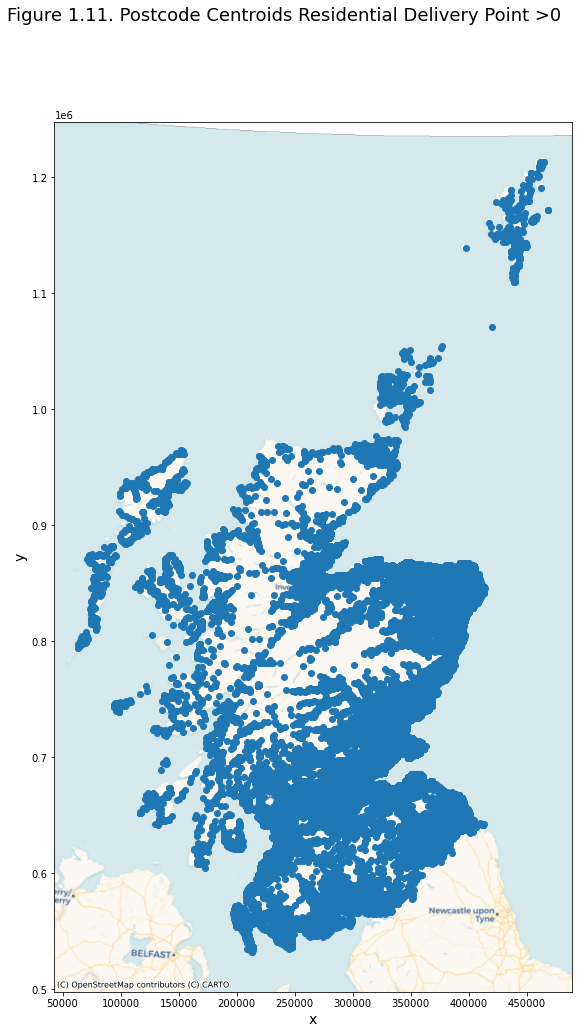

In [183]:
fig, ax = plt.subplots(figsize=(32,16))
geometry = [Point(xy) for xy in zip(postcode_centroids['EA'], postcode_centroids['NO'])]
crs = {'init': 'epsg:27700'}
postcode_centroids_geodata = gpd.GeoDataFrame(postcode_centroids, crs=crs, geometry=geometry)
plt.suptitle('Figure 1.11. Postcode Centroids Residential Delivery Point >0', fontsize=18)
plt.ylabel('y',fontsize=14)
plt.xlabel('x',fontsize=14)
postcode_centroids_geodata.plot(ax=ax, legend=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,crs='EPSG:27700')
plt.show()

# 1d. Data: Joining Postcode Centroids to SIMD by Location¶

In order to provide an evidential basis in terms of deprivation, SIMD is spatially joined to postcode centroids. This is shown at Figure 1.12 below.


In [184]:
postcode_simd_join = gpd.sjoin(postcode_centroids_geodata, simdmap_df, how='inner',op = 'intersects')

C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [185]:
postcode_simd_join.columns

Index(['PC', 'PQ', 'PR', 'TP', 'DQ', 'RP', 'BP', 'PD', 'MP', 'UM', 'EA', 'NO',
       'CY', 'RH', 'LH', 'CC', 'DC', 'WC', 'LS', 'geometry', 'index_right',
       'DataZone', 'DZName', 'LAName', 'SAPE2017', 'WAPE2017', 'Rankv2',
       'Quintilev2', 'Decilev2', 'Vigintilv2', 'Percentv2', 'IncRate',
       'IncNumDep', 'IncRankv2', 'EmpRate', 'EmpNumDep', 'EmpRank', 'HlthCIF',
       'HlthAlcSR', 'HlthDrugSR', 'HlthSMR', 'HlthDprsPc', 'HlthLBWTPc',
       'HlthEmergS', 'HlthRank', 'EduAttend', 'EduAttain', 'EduNoQuals',
       'EduPartici', 'EduUniver', 'EduRank', 'GAccPetrol', 'GAccDTGP',
       'GAccDTPost', 'GAccDTPsch', 'GAccDTSsch', 'GAccDTRet', 'GAccPTGP',
       'GAccPTPost', 'GAccPTRet', 'GAccBrdbnd', 'GAccRank', 'CrimeCount',
       'CrimeRate', 'CrimeRank', 'HouseNumOC', 'HouseNumNC', 'HouseOCrat',
       'HouseNCrat', 'HouseRank', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

Text(0.5, 0.98, 'Figure 1.12. Postcodes joined to SIMD')

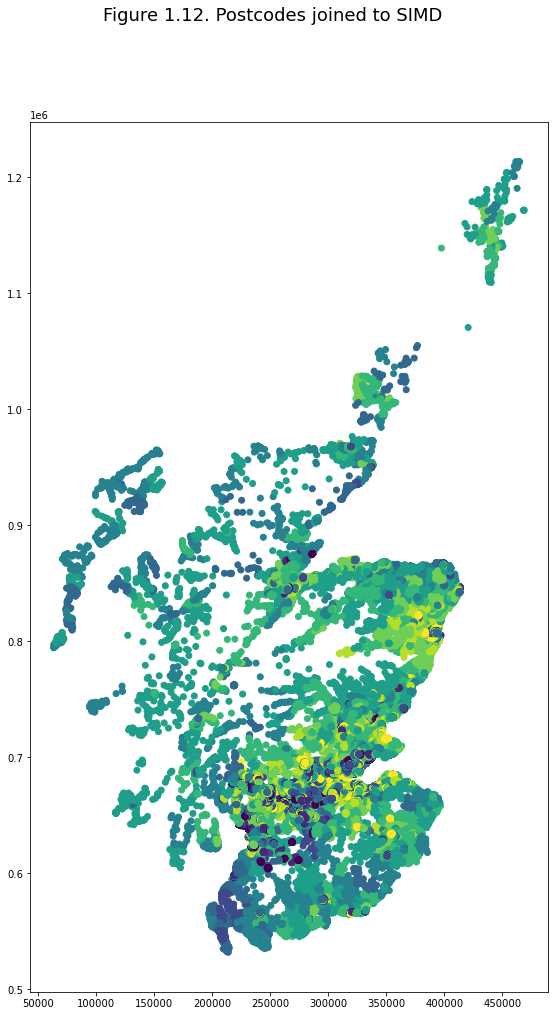

In [186]:
postcode_simd_join.plot(column='Decilev2',figsize =(18,16))
plt.suptitle('Figure 1.12. Postcodes joined to SIMD', fontsize=18)

# 2. Initial Catchment and Exploratory Data Analysis - Glasgow

An initial investigation of the problem focusses upon the local authority area of Glasgow City (**Figure 2.1**). This allows exploratory data analysis at a more detailed level.

ATMs are selected for the Glasgow City area(**Figure 2.2**) with totals of **576 free** and **187 surcharging** ATMs.

Residential postcodes are selected for the Glasgow City area (**Figure 2.3**) including the earlier join to SIMD, with a total of **13,803** postcode points.

A 800m Euclidean distance buffer representing a "20 minute neightbourhood" catchment has been selected for each ATM- free and surcharging (**Figures 2.4** and **2.5**)

Spatial joins are applied to each ATM type 800m buffer versus interseting residential postcodes, dissolved by ATM index and SIMD decile (**Figure 2.6** and **Figure 2.7**). The mean SIMD decile can be calculated for each SIMD type.



In [187]:
url = "https://geo.spatialhub.scot/geoserver/sh_las/wfs?service=WFS&request=GetFeature&typeName=pub_las&format_options=filename:Local%20Authority%20Boundaries%20-%20Scotland&outputFormat=application/json&authkey=b85aa063-d598-4582-8e45-e7e6048718fc"

response = requests.get(url, verify=False)
la_boundaries_df = gpd.read_file(response.url)
la_boundaries_df.columns
la_boundaries_glas = la_boundaries_df[la_boundaries_df['local_authority'] == 'Glasgow City']


C:\ProgramData\Anaconda3\envs\my37env\lib\site-packages\urllib3\connectionpool.py:1050: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geo.spatialhub.scot'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


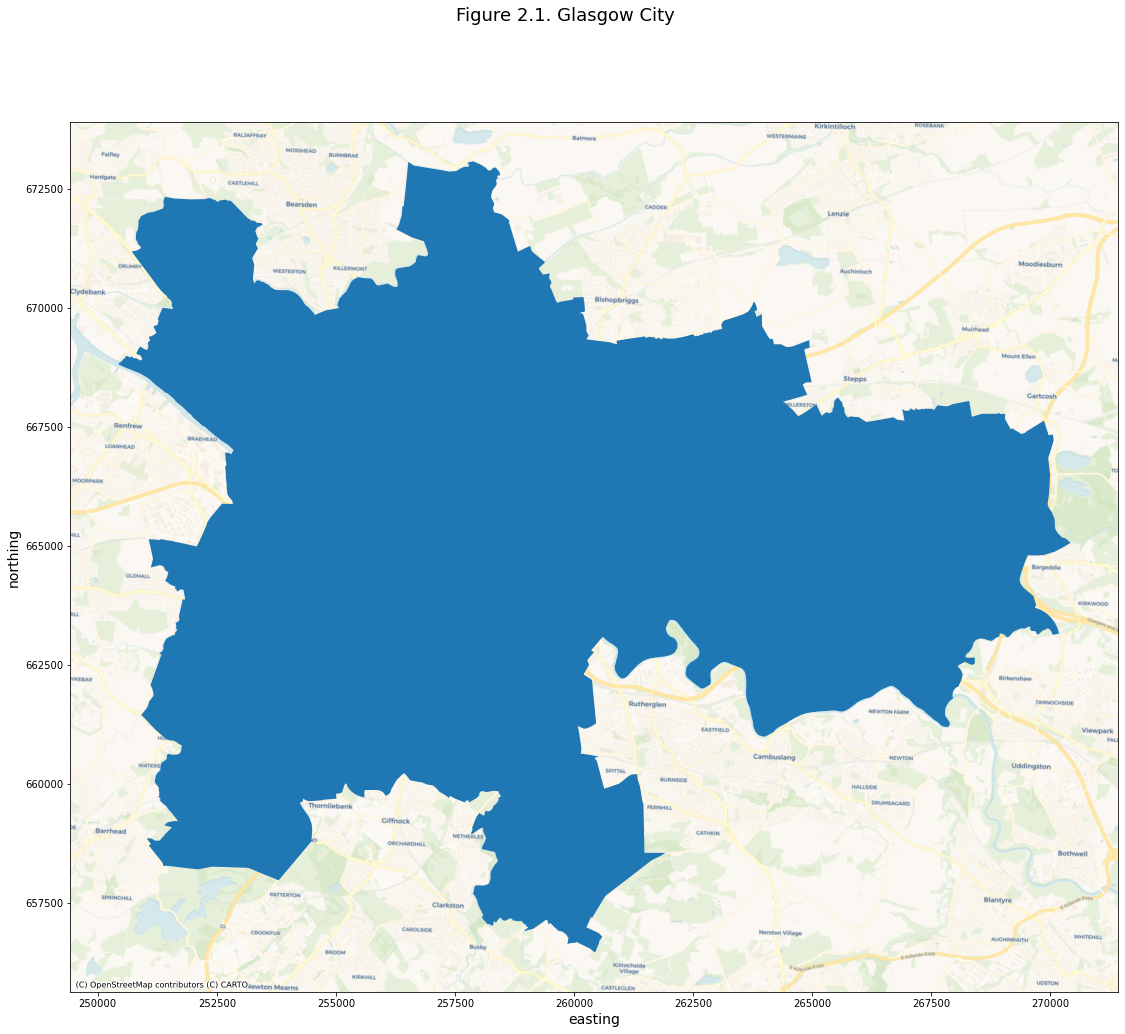

In [188]:
fig, ax = plt.subplots(figsize=(32,16))
plt.suptitle('Figure 2.1. Glasgow City', fontsize=18)
plt.ylabel('northing',fontsize=14)
plt.xlabel('easting',fontsize=14)
la_boundaries_glas.plot(ax=ax, linewidth = 0.1, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager,crs='EPSG:27700')


In [189]:
#intersect the layers and run query

In [190]:
clipped_atm_geodata = gpd.overlay(atm_geodata, la_boundaries_glas, how='intersection')

In [191]:
clipped_postcode_simd_join = gpd.overlay(postcode_simd_join, la_boundaries_glas,  how='intersection')

In [192]:
clipped_postcode_simd_join.head() 

,PC,PQ,PR,TP,DQ,RP,BP,PD,MP,UM,EA,NO,CY,RH,LH,CC,DC,WC,LS,index_right,DataZone,DZName,LAName,SAPE2017,WAPE2017,Rankv2,Quintilev2,Decilev2,Vigintilv2,Percentv2,IncRate,IncNumDep,IncRankv2,EmpRate,EmpNumDep,EmpRank,HlthCIF,HlthAlcSR,HlthDrugSR,HlthSMR,HlthDprsPc,HlthLBWTPc,HlthEmergS,HlthRank,EduAttend,EduAttain,EduNoQuals,EduPartici,EduUniver,EduRank,GAccPetrol,GAccDTGP,GAccDTPost,GAccDTPsch,GAccDTSsch,GAccDTRet,GAccPTGP,GAccPTPost,GAccPTRet,GAccBrdbnd,GAccRank,CrimeCount,CrimeRate,CrimeRank,HouseNumOC,HouseNumNC,HouseOCrat,HouseNCrat,HouseRank,Shape_Leng,Shape_Area,id,local_authority,code,hectares,geometry
0,G1 1AB,10,N,89,89,89,0,0,89,0,259624,665340,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,3754,S01010260,City Centre East - 02,Glasgow City,2544,2361,3550,3,6,11,51,7%,174,4327.0,5%,114,4694.0,75,117,87,123,7%,0%,74,4866,80%,5.83,95,3%,4%,3172,4.88,3.83,3.04,3.78,5.14,4.36,9.29,8.06,10.49,17%,1689,167,656,579.0,353,103,35%,10%,60.0,4109.183774,322943.553618,pub_las.27,Glasgow City,S12000049,17635.6,POINT (259624.000 665340.000)
1,G1 1EX,10,N,55,55,51,4,0,55,0,259670,665200,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,3754,S01010260,City Centre East - 02,Glasgow City,2544,2361,3550,3,6,11,51,7%,174,4327.0,5%,114,4694.0,75,117,87,123,7%,0%,74,4866,80%,5.83,95,3%,4%,3172,4.88,3.83,3.04,3.78,5.14,4.36,9.29,8.06,10.49,17%,1689,167,656,579.0,353,103,35%,10%,60.0,4109.183774,322943.553618,pub_las.27,Glasgow City,S12000049,17635.6,POINT (259670.000 665200.000)
2,G1 1HL,10,N,41,41,36,5,0,41,0,259374,665307,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,3754,S01010260,City Centre East - 02,Glasgow City,2544,2361,3550,3,6,11,51,7%,174,4327.0,5%,114,4694.0,75,117,87,123,7%,0%,74,4866,80%,5.83,95,3%,4%,3172,4.88,3.83,3.04,3.78,5.14,4.36,9.29,8.06,10.49,17%,1689,167,656,579.0,353,103,35%,10%,60.0,4109.183774,322943.553618,pub_las.27,Glasgow City,S12000049,17635.6,POINT (259374.000 665307.000)
3,G1 1HP,10,N,6,6,4,2,0,6,0,259393,665283,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,3754,S01010260,City Centre East - 02,Glasgow City,2544,2361,3550,3,6,11,51,7%,174,4327.0,5%,114,4694.0,75,117,87,123,7%,0%,74,4866,80%,5.83,95,3%,4%,3172,4.88,3.83,3.04,3.78,5.14,4.36,9.29,8.06,10.49,17%,1689,167,656,579.0,353,103,35%,10%,60.0,4109.183774,322943.553618,pub_las.27,Glasgow City,S12000049,17635.6,POINT (259393.000 665283.000)
4,G1 1JF,10,N,1,1,1,0,0,1,0,259435,665453,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,3754,S01010260,City Centre East - 02,Glasgow City,2544,2361,3550,3,6,11,51,7%,174,4327.0,5%,114,4694.0,75,117,87,123,7%,0%,74,4866,80%,5.83,95,3%,4%,3172,4.88,3.83,3.04,3.78,5.14,4.36,9.29,8.06,10.49,17%,1689,167,656,579.0,353,103,35%,10%,60.0,4109.183774,322943.553618,pub_las.27,Glasgow City,S12000049,17635.6,POINT (259435.000 665453.000)


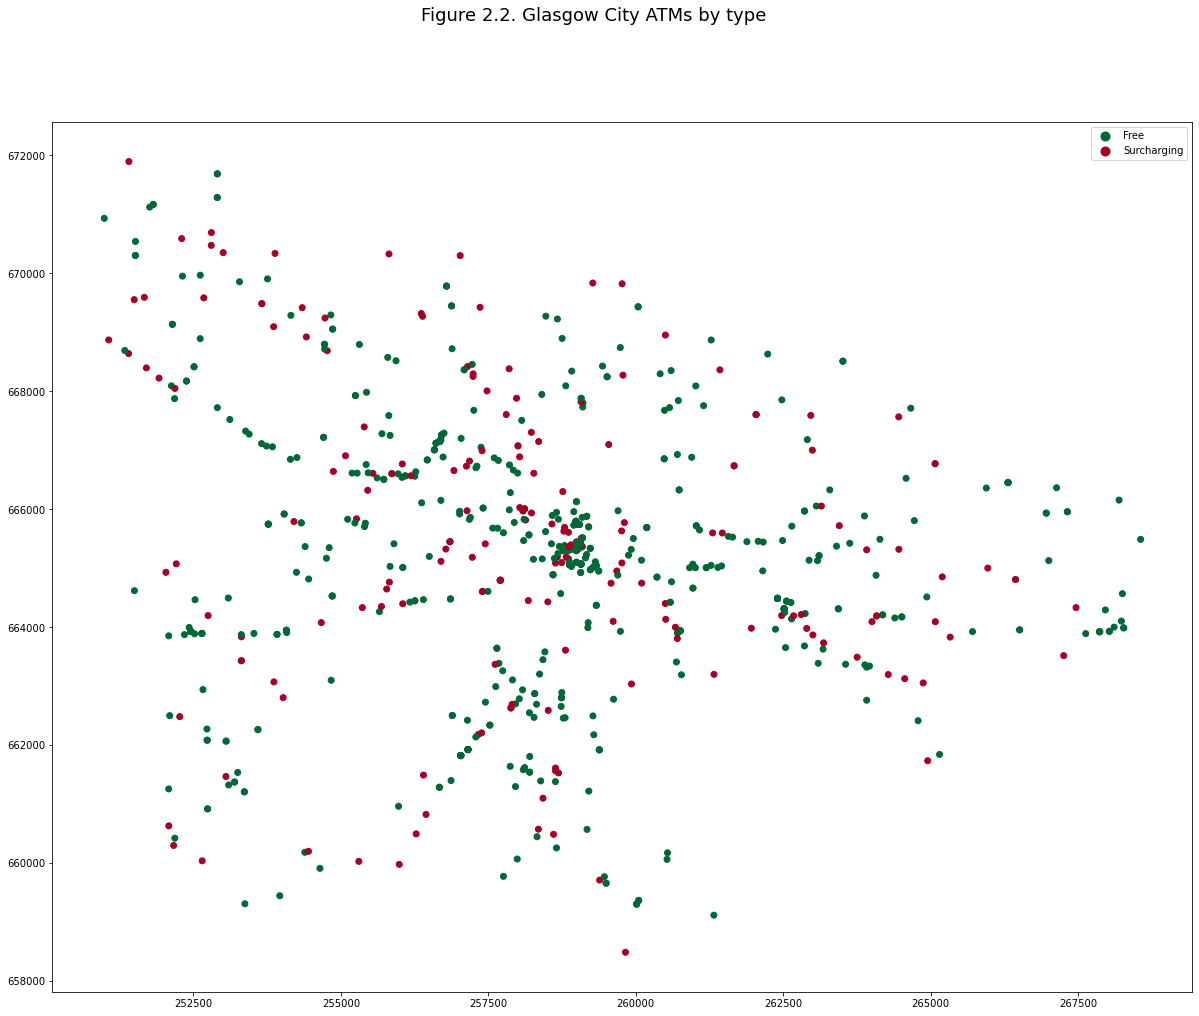

In [193]:
clipped_atm_geodata.plot(column = 'Charge Type',cmap = 'RdYlGn_r',label = 'Charge Type', legend=True,figsize=(32,16))
plt.suptitle('Figure 2.2. Glasgow City ATMs by type', fontsize=18)
plt.show()


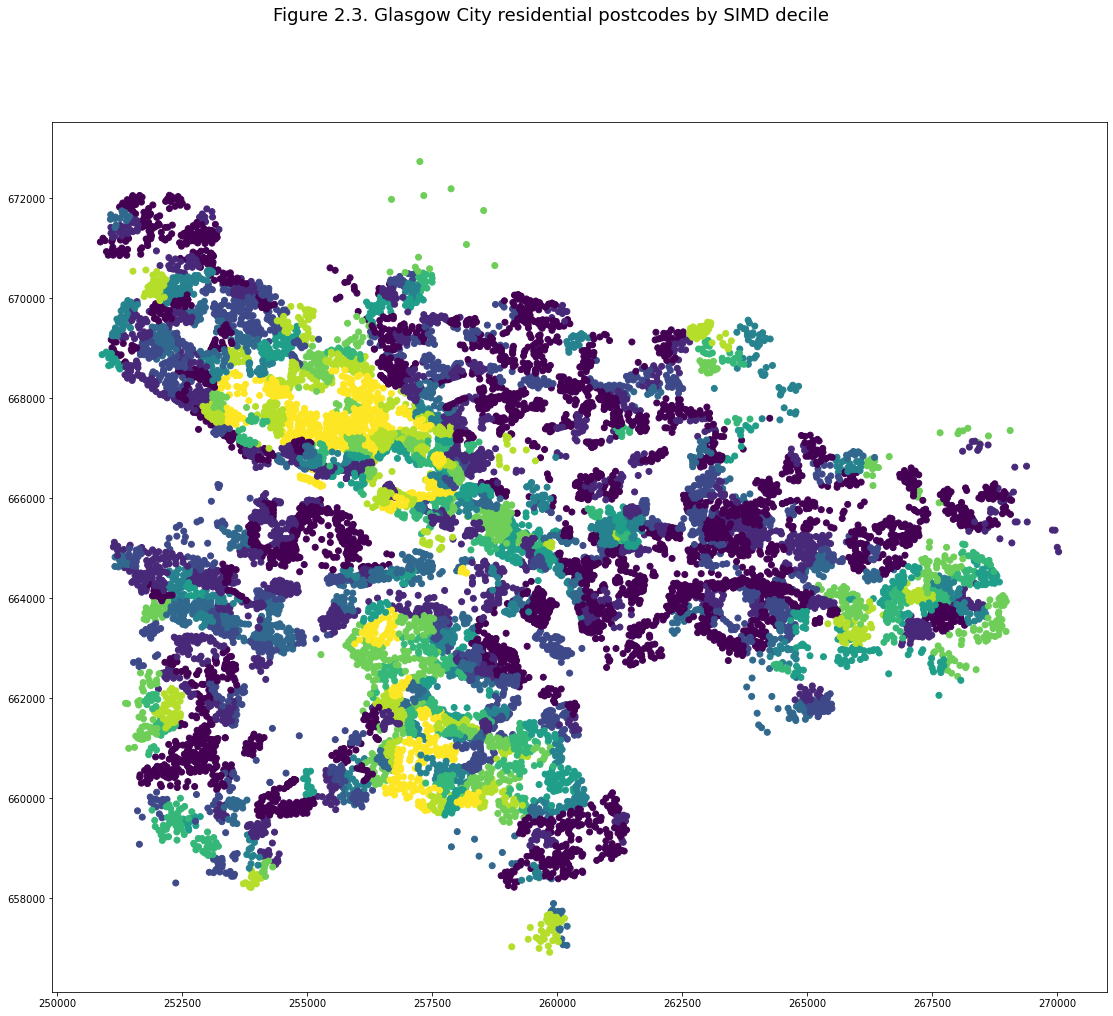

In [194]:
clipped_postcode_simd_join.plot(column='Decilev2',figsize=(32,16))
clipped_postcode_simd_join= clipped_postcode_simd_join.drop(['index_right'], axis=1)
plt.suptitle('Figure 2.3. Glasgow City residential postcodes by SIMD decile', fontsize=18)
plt.show()

In [195]:
clipped_atm_geodata_free = clipped_atm_geodata[clipped_atm_geodata['Charge Type'] == 'Free']
clipped_atm_geodata_charge = clipped_atm_geodata[clipped_atm_geodata['Charge Type'] == 'Surcharging']


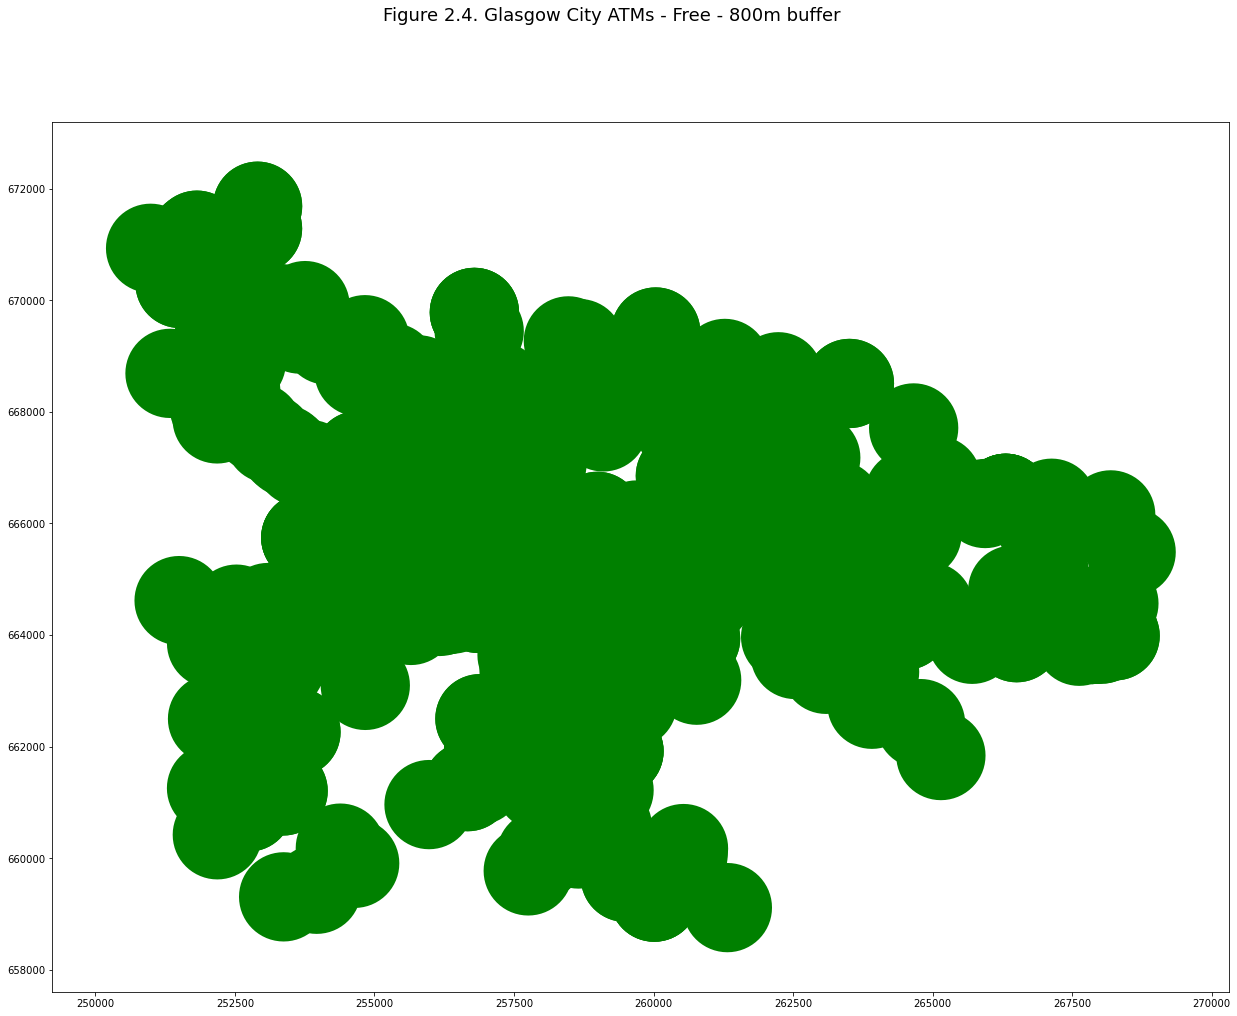

In [196]:
# can vary this instead of "(800)"
clipped_atm_buffer_free = clipped_atm_geodata_free.buffer(800)
clipped_atm_buffer_free.plot(figsize=(32,16),color='green')
plt.suptitle('Figure 2.4. Glasgow City ATMs - Free - 800m buffer', fontsize=18)
plt.show()

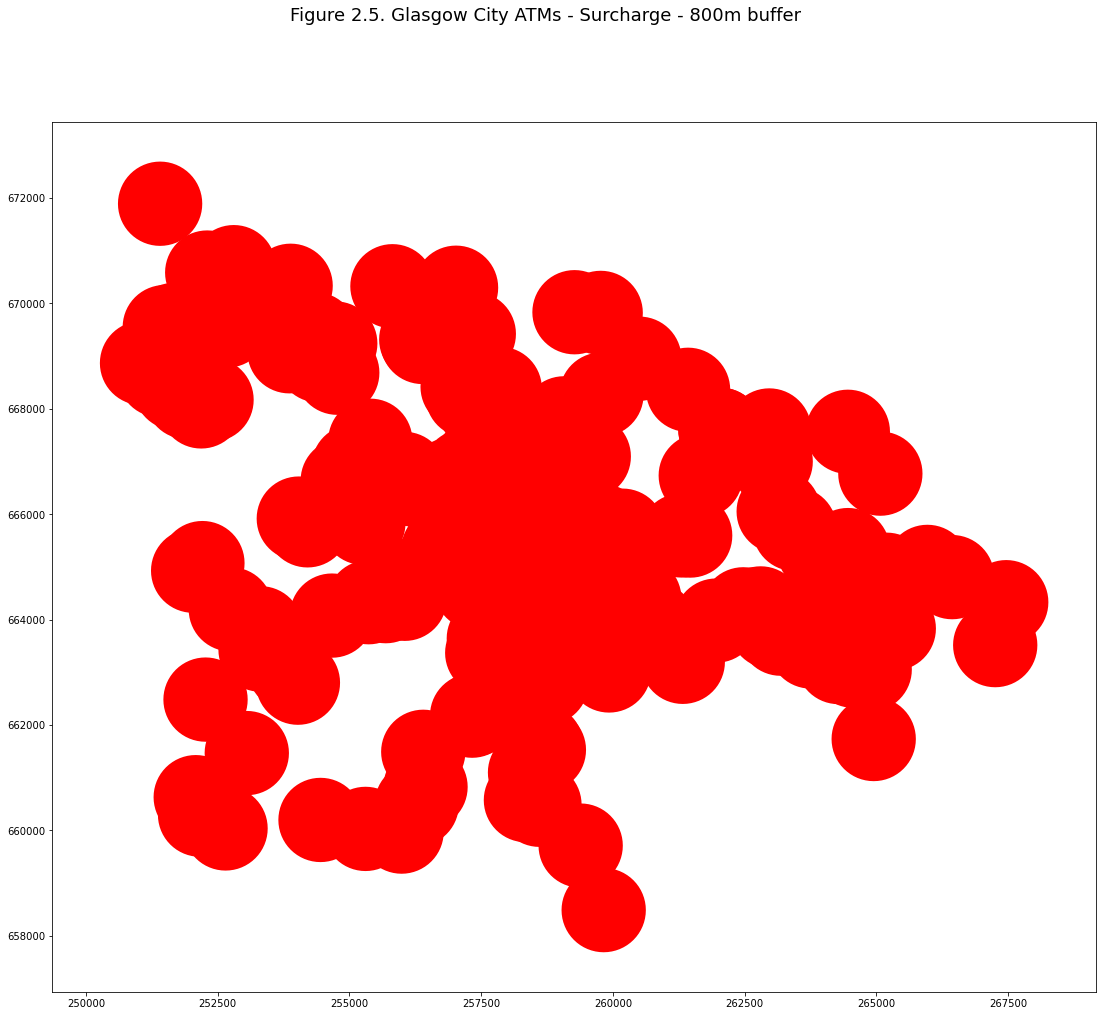

In [197]:
# can vary this instead of "(800)"
clipped_atm_buffer_charge = clipped_atm_geodata_charge.buffer(800)
clipped_atm_buffer_charge.plot(figsize=(32,16),color='red')
plt.suptitle('Figure 2.5. Glasgow City ATMs - Surcharge - 800m buffer', fontsize=18)
plt.show()

In [198]:
clipped_atm_buffer_free_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(clipped_atm_buffer_free))
clipped_atm_buffer_free_gdf.reset_index(inplace=True)
clipped_atm_buffer_charge_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(clipped_atm_buffer_charge))
clipped_atm_buffer_charge_gdf.reset_index(inplace=True)

In [199]:
clipped_atm_buffer_free_gdf.head()

,index,geometry
0,2,"POLYGON ((260676.000 665220.000, 260672.148 66..."
1,3,"POLYGON ((260113.000 665108.000, 260109.148 66..."
2,4,"POLYGON ((260127.000 665043.000, 260123.148 66..."
3,5,"POLYGON ((260127.000 665043.000, 260123.148 66..."
4,6,"POLYGON ((260127.000 665043.000, 260123.148 66..."


In [200]:
atm_buffer_free_pcsimd_join = gpd.sjoin(clipped_atm_buffer_free_gdf,clipped_postcode_simd_join, predicate="intersects")
atm_buffer_charge_pcsimd_join = gpd.sjoin(clipped_atm_buffer_charge_gdf,clipped_postcode_simd_join, predicate="intersects")


In [201]:
pd.options.display.max_columns = None
atm_buffer_free_pcsimd_join.head()

,index,geometry,index_right,PC,PQ,PR,TP,DQ,RP,BP,PD,MP,UM,EA,NO,CY,RH,LH,CC,DC,WC,LS,DataZone,DZName,LAName,SAPE2017,WAPE2017,Rankv2,Quintilev2,Decilev2,Vigintilv2,Percentv2,IncRate,IncNumDep,IncRankv2,EmpRate,EmpNumDep,EmpRank,HlthCIF,HlthAlcSR,HlthDrugSR,HlthSMR,HlthDprsPc,HlthLBWTPc,HlthEmergS,HlthRank,EduAttend,EduAttain,EduNoQuals,EduPartici,EduUniver,EduRank,GAccPetrol,GAccDTGP,GAccDTPost,GAccDTPsch,GAccDTSsch,GAccDTRet,GAccPTGP,GAccPTPost,GAccPTRet,GAccBrdbnd,GAccRank,CrimeCount,CrimeRate,CrimeRank,HouseNumOC,HouseNumNC,HouseOCrat,HouseNCrat,HouseRank,Shape_Leng,Shape_Area,id,local_authority,code,hectares
0,2,"POLYGON ((260676.000 665220.000, 260672.148 66...",8028,G4 0RD,10,N,20,20,19,1,0,20,0,260036,665598,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,S01010259,City Centre East - 01,Glasgow City,1401,1182,1740,2,3,5,25,18%,247,1794.0,13%,150,1970.0,135,240,204,153,14%,12%,134,1824,77%,5.46,206,0%,6%,1840,4.43,3.8,3.67,2.51,4.77,4.69,9.01,8.0,11.81,1%,2128,33,237,2914.0,204,102,27%,13%,110.0,2703.46715,148232.499667,pub_las.27,Glasgow City,S12000049,17635.6
44,51,"POLYGON ((260494.000 664882.000, 260490.148 66...",8028,G4 0RD,10,N,20,20,19,1,0,20,0,260036,665598,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,S01010259,City Centre East - 01,Glasgow City,1401,1182,1740,2,3,5,25,18%,247,1794.0,13%,150,1970.0,135,240,204,153,14%,12%,134,1824,77%,5.46,206,0%,6%,1840,4.43,3.8,3.67,2.51,4.77,4.69,9.01,8.0,11.81,1%,2128,33,237,2914.0,204,102,27%,13%,110.0,2703.46715,148232.499667,pub_las.27,Glasgow City,S12000049,17635.6
369,489,"POLYGON ((260498.000 665973.000, 260494.148 66...",8028,G4 0RD,10,N,20,20,19,1,0,20,0,260036,665598,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,S01010259,City Centre East - 01,Glasgow City,1401,1182,1740,2,3,5,25,18%,247,1794.0,13%,150,1970.0,135,240,204,153,14%,12%,134,1824,77%,5.46,206,0%,6%,1840,4.43,3.8,3.67,2.51,4.77,4.69,9.01,8.0,11.81,1%,2128,33,237,2914.0,204,102,27%,13%,110.0,2703.46715,148232.499667,pub_las.27,Glasgow City,S12000049,17635.6
370,490,"POLYGON ((260722.000 665318.000, 260718.148 66...",8028,G4 0RD,10,N,20,20,19,1,0,20,0,260036,665598,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,S01010259,City Centre East - 01,Glasgow City,1401,1182,1740,2,3,5,25,18%,247,1794.0,13%,150,1970.0,135,240,204,153,14%,12%,134,1824,77%,5.46,206,0%,6%,1840,4.43,3.8,3.67,2.51,4.77,4.69,9.01,8.0,11.81,1%,2128,33,237,2914.0,204,102,27%,13%,110.0,2703.46715,148232.499667,pub_las.27,Glasgow City,S12000049,17635.6
371,492,"POLYGON ((260757.000 665503.000, 260753.148 66...",8028,G4 0RD,10,N,20,20,19,1,0,20,0,260036,665598,S92000003,NaN,S08000031,NaN,S12000049,S13002976,S,S01010259,City Centre East - 01,Glasgow City,1401,1182,1740,2,3,5,25,18%,247,1794.0,13%,150,1970.0,135,240,204,153,14%,12%,134,1824,77%,5.46,206,0%,6%,1840,4.43,3.8,3.67,2.51,4.77,4.69,9.01,8.0,11.81,1%,2128,33,237,2914.0,204,102,27%,13%,110.0,2703.46715,148232.499667,pub_las.27,Glasgow City,S12000049,17635.6


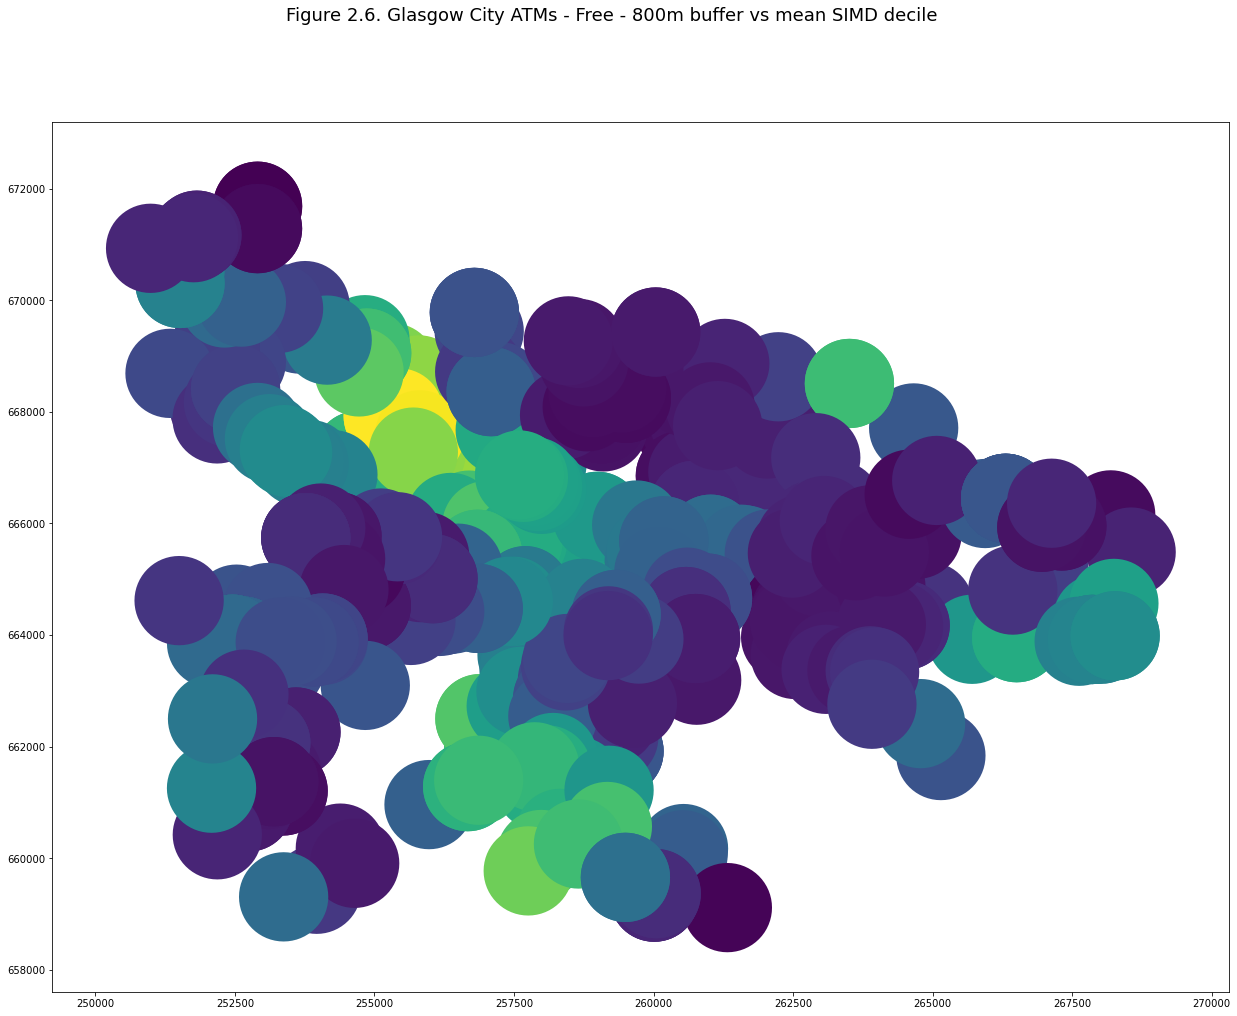

In [202]:
atm_buffer_free_pcsimd_join_av_decile = atm_buffer_free_pcsimd_join.dissolve(by='index', aggfunc='mean')
atm_buffer_free_pcsimd_join_av_decile.plot(figsize=(32,16),column='Decilev2')
plt.suptitle('Figure 2.6. Glasgow City ATMs - Free - 800m buffer vs mean SIMD decile', fontsize=18)
plt.show()

In [203]:
#this may change if buffer or RP values changed
atm_buffer_free_pcsimd_join_av_decile['Decilev2'].mean()

576

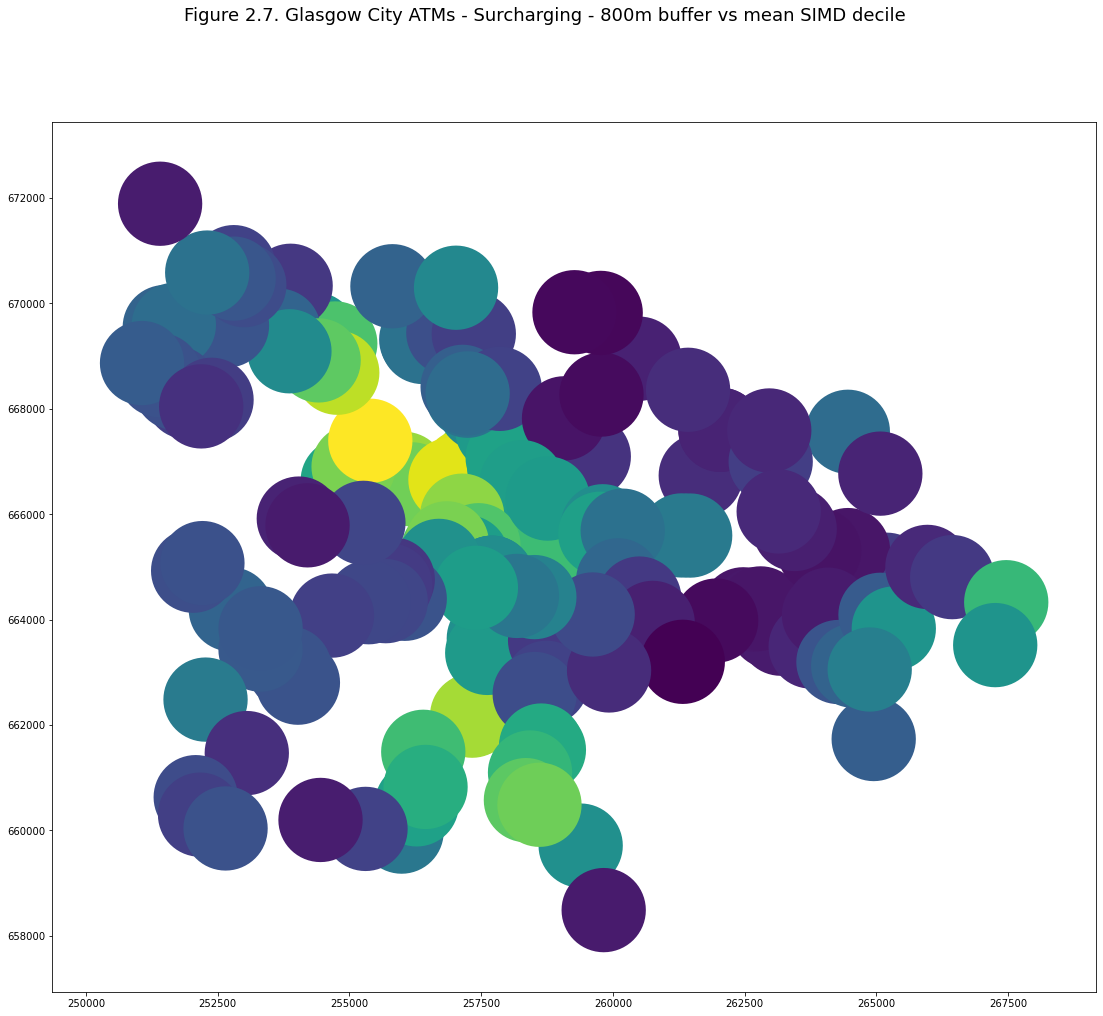

In [204]:
atm_buffer_charge_pcsimd_join_av_decile = atm_buffer_charge_pcsimd_join.dissolve(by='index', aggfunc='mean')
atm_buffer_charge_pcsimd_join_av_decile.plot(figsize=(32,16),column ='Decilev2')
plt.suptitle('Figure 2.7. Glasgow City ATMs - Surcharging - 800m buffer vs mean SIMD decile', fontsize=18)
plt.show()

In [205]:
#this may change if buffer or RP values changed
atm_buffer_charge_pcsimd_join_av_decile['Decilev2'].mean()

3.8982410600893713

# 2. Glasgow Data: Initial Conclusions

A focus on Glasgow, with a manageable subset of data, indicates a notional disadvantage for more deprived areas, with the mean SIMD decile for free-to-use ATMs of 4.3 versus a mean SIMD decile of 3.9 for surcharging ATMs.

The next steps are to repeat this analysis with a two-step floating catchment analysis (2SFCA, Luo and Wang, 2003), for Glasgow and Scotland, creating catchments from postcodes based upon clustering using SIMD and residential delivery point numbers as a proxy for population.


# 3. 2-Step Floating Catchment Analysis